### Imports

In [1]:
# general imports 
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
sns.set()

# model
from lightgbm import LGBMClassifier

# optuna
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) 

# shap
import shap
shap.initjs()

# utils
from utils import *

In [2]:
df_train = pd.read_csv("train.csv")
df_valid = pd.read_csv("valid.csv")
df_test = pd.read_csv("test.csv")

X_train, y_train, X_valid, y_valid, X_test, y_test = with_resampling(df_train, df_valid, df_test)

### Optuna Hyperparameter Tuning

#### Finding hyperparameter with the best recall

In [3]:
#creating an objective function
def objective(trial):

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    lgb = LGBMClassifier(seed=20, **param)
    lgb.fit(X_train, y_train)

    #classifying validation data
    y_pred = lgb.predict(X_valid)

    #measuring the evaluation metrics for the model
    recall = recall_score(y_valid, y_pred)
    return recall

In [4]:
#running 100 trials to find the hyperparameters that give the highest evaluation metric score
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial : objective(trial) ,n_trials=50)
print("Number of finished trials: ", len(study.trials))

[LightGBM] [Warning] feature_fraction is set=0.8131560896330257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8131560896330257
[LightGBM] [Warning] lambda_l1 is set=0.5991053314718446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5991053314718446
[LightGBM] [Warning] bagging_fraction is set=0.6418801562655072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6418801562655072
[LightGBM] [Warning] lambda_l2 is set=0.0006320815474499335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006320815474499335
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6578794152490371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6578794152490371
[LightGBM] [Warning] lambda_l1 is set=0.00016651206632023805, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00016651206632023805
[LightGBM] [Warning] ba

In [5]:
#view the best hyperparameters
trial = study.best_trial
print(f"Trial of Choice: ")
print(f"\tnumber: {trial.number}")
print(f"\tparams: {trial.params}")
print(f"\tvalues: {trial.values}")

Trial of Choice: 
	number: 19
	params: {'lambda_l1': 5.730619417415307e-06, 'lambda_l2': 0.049327950356718435, 'num_leaves': 2, 'feature_fraction': 0.7707312209313777, 'bagging_fraction': 0.7772103078830739, 'bagging_freq': 2, 'min_child_samples': 30}
	values: [0.9477611940298507]


In [6]:
test = LGBMClassifier(seed = 20)
test.set_params(**trial.params)
test.fit(X_train,y_train)

# make predictions for validation data
y_pred = test.predict(X_valid)
predictions = [round(value) for value in y_pred]


[LightGBM] [Warning] feature_fraction is set=0.7707312209313777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7707312209313777
[LightGBM] [Warning] lambda_l1 is set=5.730619417415307e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.730619417415307e-06
[LightGBM] [Warning] bagging_fraction is set=0.7772103078830739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7772103078830739
[LightGBM] [Warning] lambda_l2 is set=0.049327950356718435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.049327950356718435
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


In [7]:

# evaluate predictions
get_scores(y_valid, predictions)

Precision: 0.079
Accuracy: 0.346
Recall: 0.948
F1: 0.146
Fbeta: 0.297
ROC AUC: 0.628
PR AUC: 0.078


<AxesSubplot: title={'center': 'Tuned for recall'}, xlabel='Predictions', ylabel='True Labels'>

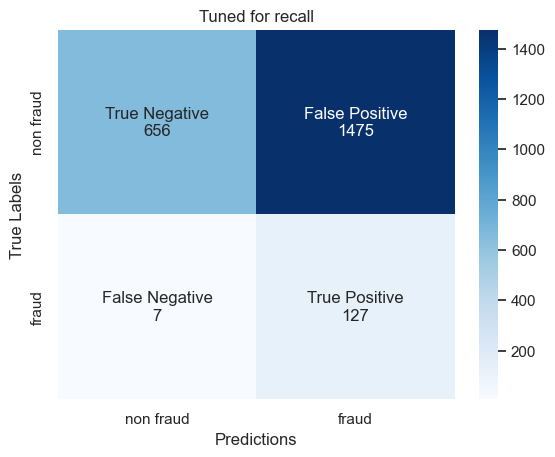

In [8]:
get_confusion_matrix(y_valid, y_pred, "Tuned for recall")

#### Finding hyperparameter with the best f2 score

In [9]:
#creating an objective function
def objective(trial):

    #hyperparameters to tune
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    #creating the model
    lgb = LGBMClassifier(seed = 20, **param)
    lgb.fit(X_train, y_train)

    #classifying validation data
    y_pred = lgb.predict(X_valid)

    #measuring the evaluation metrics for the model
    fbeta = fbeta_score(y_valid, y_pred, beta = 2)
    return fbeta

In [10]:
study2 = optuna.create_study(direction="maximize")
study2.optimize(lambda trial : objective(trial) ,n_trials=100)
print("Number of finished trials: ", len(study2.trials))

[LightGBM] [Warning] feature_fraction is set=0.9286946695291971, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9286946695291971
[LightGBM] [Warning] lambda_l1 is set=4.004744374378338e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.004744374378338e-06
[LightGBM] [Warning] bagging_fraction is set=0.9193734927643712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9193734927643712
[LightGBM] [Warning] lambda_l2 is set=5.175007959329564e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.175007959329564e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4534287723569331, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4534287723569331
[LightGBM] [Warning] lambda_l1 is set=2.876988660555316e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.876988660555316e-06
[LightGBM] [Warning

In [11]:
#view the best hyperparameters
trial = study2.best_trial
print(f"Trial of Choice: ")
print(f"\tnumber: {trial.number}")
print(f"\tparams: {trial.params}")
print(f"\tvalues: {trial.values}")

Trial of Choice: 
	number: 88
	params: {'lambda_l1': 1.3442098316104387, 'lambda_l2': 6.75879039427959e-06, 'num_leaves': 100, 'feature_fraction': 0.9986133441767814, 'bagging_fraction': 0.8396698671481069, 'bagging_freq': 7, 'min_child_samples': 83}
	values: [0.4263157894736842]


In [12]:
test = LGBMClassifier(seed = 20)
test.set_params(**trial.params)
test.fit(X_train,y_train)

# make predictions for validation data
y_pred = test.predict(X_valid)
predictions = [round(value) for value in y_pred]


[LightGBM] [Warning] feature_fraction is set=0.9986133441767814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9986133441767814
[LightGBM] [Warning] lambda_l1 is set=1.3442098316104387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3442098316104387
[LightGBM] [Warning] bagging_fraction is set=0.8396698671481069, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396698671481069
[LightGBM] [Warning] lambda_l2 is set=6.75879039427959e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.75879039427959e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


In [13]:
# evaluate predictions
get_scores(y_valid, predictions)

Precision: 0.196
Accuracy: 0.830
Recall: 0.604
F1: 0.296
Fbeta: 0.426
ROC AUC: 0.724
PR AUC: 0.142


<AxesSubplot: title={'center': 'Tuned for fbeta'}, xlabel='Predictions', ylabel='True Labels'>

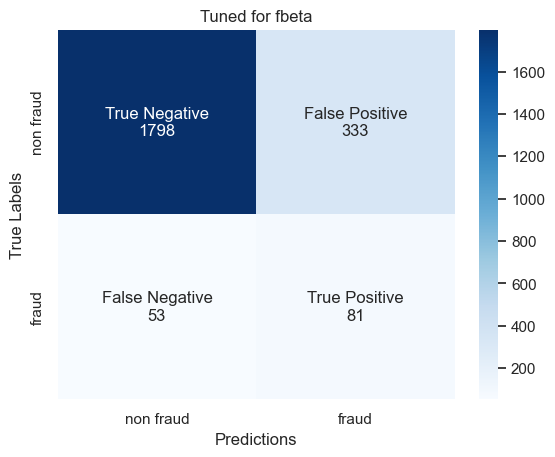

In [14]:
#Confusion Matrix
get_confusion_matrix(y_valid, y_pred, "Tuned for fbeta")

#### Making predictions on test set

In [24]:
y_pred = test.predict(X_test)
predictions = [round(value) for value in y_pred]

In [25]:
get_scores(y_test, predictions)

Precision: 0.163
Accuracy: 0.837
Recall: 0.425
F1: 0.236
Fbeta: 0.322
ROC AUC: 0.644
PR AUC: 0.103


<AxesSubplot: title={'center': 'Test set results'}, xlabel='Predictions', ylabel='True Labels'>

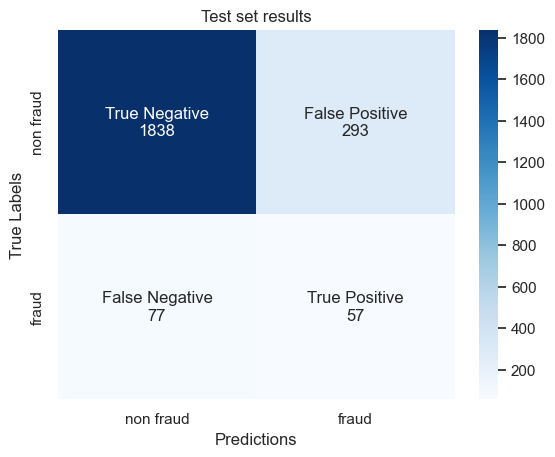

In [26]:
#Confusion Matrix
get_confusion_matrix(y_test, y_pred, "Test set results")

### SHAP

In [15]:
#creating a feature list
features  = df_train.drop('FraudFound_P', axis=1).columns.tolist()
feature_dict = {}
for num in range(53):
    feature_key = "f" + str(num)
    feature_dict[feature_key] = features[num]
print(feature_dict)

{'f0': 'MonthClaimed', 'f1': 'VehiclePrice', 'f2': 'Deductible', 'f3': 'DriverRating', 'f4': 'Days_Policy_Accident', 'f5': 'Days_Policy_Claim', 'f6': 'PastNumberOfClaims', 'f7': 'AgeOfVehicle', 'f8': 'AgeOfPolicyHolder', 'f9': 'NumberOfSuppliments', 'f10': 'AddressChange_Claim', 'f11': 'NumberOfCars', 'f12': 'Year', 'f13': 'AccidentArea_IsUrban', 'f14': 'Sex_IsMale', 'f15': 'Fault_IsPolicyholder', 'f16': 'PoliceReportFiled_IsYes', 'f17': 'WitnessPresent_IsYes', 'f18': 'AgentType_IsExternal', 'f19': 'isWithinAgeRange_IsTrue', 'f20': 'Make_Accura', 'f21': 'Make_BMW', 'f22': 'Make_Chevrolet', 'f23': 'Make_Dodge', 'f24': 'Make_Ford', 'f25': 'Make_Honda', 'f26': 'Make_Jaguar', 'f27': 'Make_Lexus', 'f28': 'Make_Mazda', 'f29': 'Make_Mecedes', 'f30': 'Make_Mercury', 'f31': 'Make_Nisson', 'f32': 'Make_Pontiac', 'f33': 'Make_Porche', 'f34': 'Make_Saab', 'f35': 'Make_Saturn', 'f36': 'Make_Toyota', 'f37': 'Make_VW', 'f38': 'MaritalStatus_Divorced', 'f39': 'MaritalStatus_Married', 'f40': 'MaritalSt

In [16]:
X_display = df_train.drop('FraudFound_P', axis=1)

In [17]:
explainer = shap.TreeExplainer(test)
shap_values = explainer.shap_values(X_train[1:1000,:])

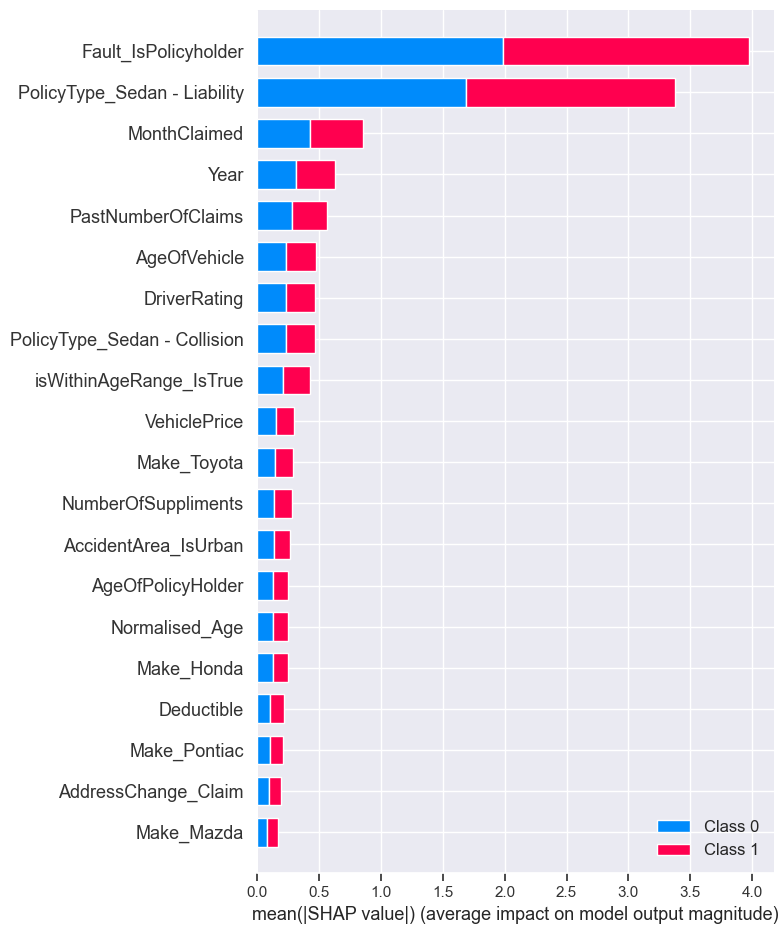

In [21]:
#featuere importance
shap.summary_plot(shap_values, X_train[1:1000,:], feature_names=features, plot_type="bar")